In [1]:
from omegaconf import OmegaConf

cfg = OmegaConf.load("/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference/conf/config.yaml")

cfg

{'hydra': {'job': {'chdir': False, 'name': 'Inference'}, 'run': {'dir': './outputs/${hydra:job.name}'}}, 'seed': 42, 'models': [{'name': 'gc-baseline-run01', 'type': 'gc-baseline', 'code_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline', 'config_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/conf/config.yaml', 'weights': ['/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/runs/RUN01/SEED21/checkpoint/model.iter003750.pth', '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/runs/RUN01/SEED42/checkpoint/model.iter003750.pth', '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/runs/RUN01/SEED84/checkpoint/model.iter003750.pth']}, {'name': 'gc-baseline-run02', 'type': 'gc-baseline', 'code_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline', 'config_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/conf/config_tuned_config.yaml', 'weights': ['/iopsstor/scratch/cscs/stefschu/DSM500_FPR/mo

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference')

from lib.utils import build_activities

activities = build_activities(cfg)
#activities = activities[
len(activities)

189

In [4]:
activities = build_activities(
    cfg=OmegaConf.load("supplementary_files/inference/conf/config.yaml")
)

print("Activities to run:", len(activities))
print("An activity:", activities[5])

Activities to run: 189
An activity: 
        Activity ID:       5
        Model name:        gc-baseline-run01
        Model type:        gc-baseline
        Model weights:     ./DSM500_FPR/modulus-baseline/runs/RUN01/SEED21/checkpoint/model.iter003750.pth
        Initial condition: 275


In [9]:
df

,activity_id,name,type,weights,variable,region,metric,step,value
0,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,0,0.000000
1,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,1,1152.000000
2,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,2,1288.000000
3,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,3,1344.000000
4,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,4,1400.000000
...,...,...,...,...,...,...,...,...,...
762043,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,23,0.995642
762044,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,24,0.996500
762045,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,25,0.995884
762046,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,26,0.996870


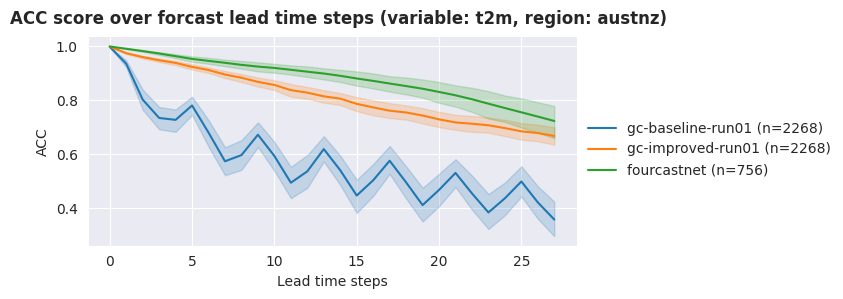

In [ ]:
df_subset = df[(df.metric == "acc") & (df.variable == "t2m") & (df.region == "austnz")]

with sns.axes_style("darkgrid"):
    ax = sns.relplot(data=df_subset, x="step", y="value", hue="label")
    ax.figure.suptitle("ACC score over forcast lead time steps (variable: t2m, region: austnz)")
    ax.set_axis_labels("Lead time steps", "ACC")

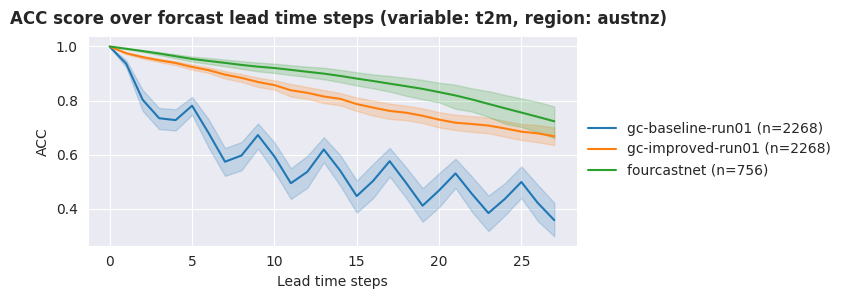

In [7]:
df_subset = df[(df.metric == "acc") & (df.variable == "t2m") & (df.region == "austnz")]

df_subset = df_subset.copy()
df_subset["label"] = df_subset.groupby("name")["step"].transform("count")
df_subset["label"] = df_subset["name"] + " (n=" + df_subset["label"].astype(str) + ")"


with sns.axes_style("darkgrid"):
    ax = sns.relplot(
        data=df_subset,
        x="step",
        y="value",
        hue="label",
        kind="line",
        height=3,
        aspect=2.5
    )

    # sns.move_legend(
    #     ax, "lower center",
    #     bbox_to_anchor=(.4, -.1), ncol=3, title=None, frameon=False
    # )

    ax._legend.set_title(None)

    ax.figure.suptitle("ACC score over forcast lead time steps (variable: t2m, region: austnz)", fontweight='bold')
    ax.figure.subplots_adjust(top=0.89, left=.25)

    ax.set_titles("")
    ax.set_axis_labels("Lead time steps", "ACC")

    #g.ax.text(0.95, 0.95, f"n = {len(global_all_rmse)}", transform=g.ax.transAxes, ha='right', va='top', fontsize=10)

In [4]:
for activity in activities:
    assert activity.is_already_computed()

In [5]:
import torch
import math

container = []
for activity in activities:
    data = torch.load(activity.file_path_metrics, weights_only=False)
    for (variable, region), metrics in data['metrics'].items():
        assert variable == metrics["slice"]["variable"]
        assert region == metrics["slice"]["region"]

        for metric in ["rmse", "acc"]:
            for step in range(cfg.inference.rollout_steps):
                container.append({
                    'activity_id': activity.id,
                    'name': activity.model_name,
                    'type': activity.model_type,
                    'weights': activity.weights_file_path,
                    'variable': variable,
                    'region': region,
                    'metric': metric,
                    'step': step,
                    'value': metrics[metric][step]
                })

#print(len(container))

import pandas as pd

df = pd.DataFrame(container)

#print(df.variable.unique(), df.region.unique())

#df = df[df["variable"].isin(['all', 'z_500', 't_850', 't2m'])]
#df = df[df["region"].isin(["global", "n.hem", "s.hem", "europe", "austnz"])]
df['weights'] = df['weights'].str.replace('/iopsstor/scratch/cscs/stefschu/DSM500_FPR', '.', regex=False)
df['weights'] = df['weights'].str.replace('/runs/RUN01', '', regex=False)
df['weights'] = df['weights'].str.replace('/checkpoint', '', regex=False)
df['name'] = df['name'].str.replace('baseline-run02', 'improved-run01', regex=False)
df

,activity_id,name,type,weights,variable,region,metric,step,value
0,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,0,0.000000
1,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,1,1152.000000
2,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,2,1288.000000
3,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,3,1344.000000
4,0,gc-baseline-run01,gc-baseline,./modulus-baseline/SEED21/model.iter003750.pth,all,global,rmse,4,1400.000000
...,...,...,...,...,...,...,...,...,...
762043,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,23,0.995642
762044,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,24,0.996500
762045,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,25,0.995884
762046,188,fourcastnet,fcn,./fourcastnet-92260c1s/iter3750.pth,v_850,austnz,acc,26,0.996870


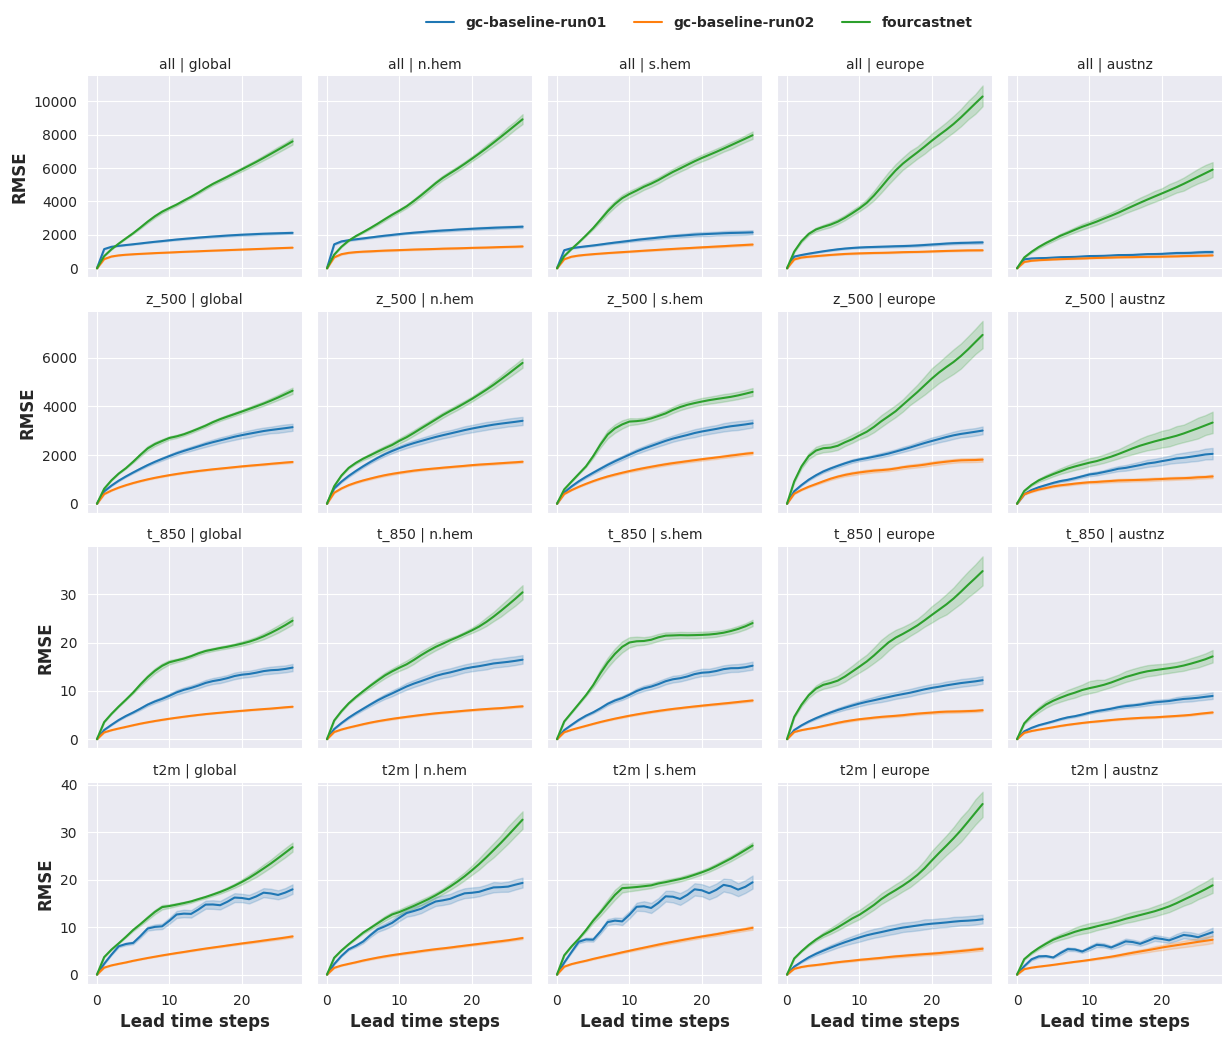

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style("darkgrid"):
    ax = sns.relplot(
        data=df[df.metric == "rmse"],
        x="step",
        y="value",
        col="region",
        row="variable",
        hue="name",

        kind="line",
        facet_kws={"sharey": "row"},
        height=2.5,
    )

    ax.set_titles(row_template="{row_name}", col_template="{col_name}")
    ax.set_axis_labels("Lead time steps", "RMSE", fontsize=12, fontweight='bold')

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, fontsize=14, prop={'weight': 'bold'}
    )

    for ax in ax.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), fontweight='bold', fontsize=12)
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=12)

    plt.savefig("/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference/plots/rmse.png", dpi=300, bbox_inches="tight") 
    plt.show()

In [63]:
import torch
import math

container = []
for activity in activities:
    data = torch.load(activity.file_path_metrics, weights_only=False)
    for (variable, region), metrics in data['metrics'].items():
        assert variable == metrics["slice"]["variable"]
        assert region == metrics["slice"]["region"]

        for metric in ["rmse", "acc"]:
            for step in range(cfg.inference.rollout_steps):
                container.append({
                    'activity_id': activity.id,
                    'name': activity.model_name,
                    'type': activity.model_type,
                    'weights': activity.weights_file_path,
                    'variable': variable,
                    'region': region,
                    'metric': metric,
                    'step': step,
                    'value': metrics[metric][step]
                })

print(len(container))

import pandas as pd

df = pd.DataFrame(container)

print(df.variable.unique(), df.region.unique())

# df = df[df["variable"].isin(['all', 'z_500', 't_850', 't2m', 'msl', '10u', '10v', 'u_850', 'v_850'])]
# df = df[df["region"].isin(["global", "n.hem", "tropics", "s.hem", "europe", "n.amer", "e.asia", "austnz"])]
df = df[df["variable"].isin(['all', 'z_500', 't_850', 't2m'])]
df = df[df["region"].isin(["global", "n.hem", "s.hem", "europe", "austnz"])]

df

762048
['all' 'z_500' 't_850' 't2m' 'msl' '10u' '10v' 'u_850' 'v_850'] ['global' 'n.hem' 'tropics' 's.hem' 'europe' 'n.amer' 'e.asia' 'austnz']


,activity_id,name,type,weights,variable,region,metric,step,value
0,0,gc-baseline-run01,gc-baseline,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/mod...,all,global,rmse,0,0.000000
1,0,gc-baseline-run01,gc-baseline,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/mod...,all,global,rmse,1,1152.000000
2,0,gc-baseline-run01,gc-baseline,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/mod...,all,global,rmse,2,1288.000000
3,0,gc-baseline-run01,gc-baseline,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/mod...,all,global,rmse,3,1344.000000
4,0,gc-baseline-run01,gc-baseline,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/mod...,all,global,rmse,4,1400.000000
...,...,...,...,...,...,...,...,...,...
759803,188,fourcastnet,fcn,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/fou...,t2m,austnz,acc,23,0.820651
759804,188,fourcastnet,fcn,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/fou...,t2m,austnz,acc,24,0.816012
759805,188,fourcastnet,fcn,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/fou...,t2m,austnz,acc,25,0.811631
759806,188,fourcastnet,fcn,/iopsstor/scratch/cscs/stefschu/DSM500_FPR/fou...,t2m,austnz,acc,26,0.802458


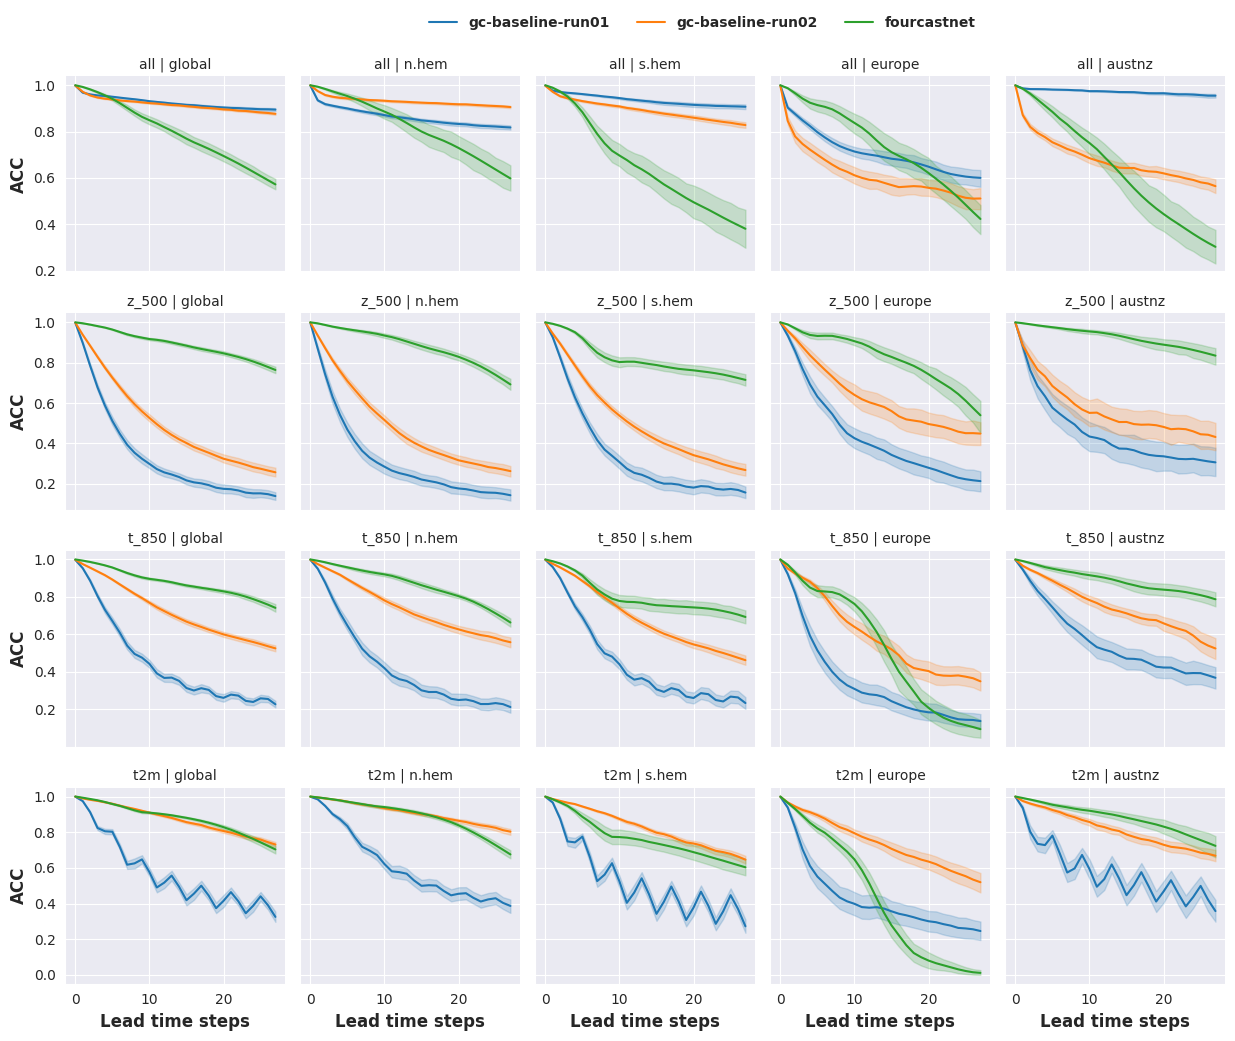

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style("darkgrid"):
    ax = sns.relplot(
        data=df[df.metric == "acc"],
        x="step",
        y="value",
        col="region",
        row="variable",
        hue="name",

        kind="line",
        facet_kws={"sharey": "row"},
        height=2.5,
    )

    ax.set_titles(row_template="{row_name}", col_template="{col_name}")
    ax.set_axis_labels("Lead time steps", "ACC", fontsize=12, fontweight='bold')

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, fontsize=14, prop={'weight': 'bold'}
    )

    for ax in ax.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), fontweight='bold', fontsize=12)
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=12)

    plt.savefig("/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference/plots/acc.png", dpi=300, bbox_inches="tight") 
    plt.show()